# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
#функция паддинга
def padd(x, padding=(0,0) ):
    a = x.shape[0]
    b = x.shape[1]+2*padding[0]
    c = x.shape[2]+2*padding[1]
    n = torch.zeros(a, b, c)
    n[:,padding[0]:b-padding[0], padding[1]:c-padding[1]] = x
    return n

In [2]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    a = torch.Tensor(x.shape)
    a[:,:,:] = x[:,:,:]
    if len(a.shape) == 3:
        a = a.unsqueeze_(0);
    
    h = math.floor((a.shape[2] + 2*padding[0] - kernel.shape[1]) / stride[0] + 1)
    w = math.floor((a.shape[3] + 2*padding[1] - kernel.shape[2]) / stride[1] + 1)
    out = torch.FloatTensor(a.shape[0], h, w)
    
    y = torch.zeros(a.shape[0], a.shape[1], a.shape[2], a.shape[3])
    
    for i in range(a.shape[0]):
        y[i] = padd(a[i], padding)
        for j in range(h):
            for k in range(w):
                out[i][j][k] = torch.sum(y[i, 
                                           :, 
                                           (j * stride[0]):(kernel.shape[1] + j * stride[0]), 
                                           (k * stride[1]):(kernel.shape[2] + k * stride[1])] * kernel)
    out = out.squeeze_(0)
    return out
    
    

## Тестируем функцию свертки

### Загружаем картинку 

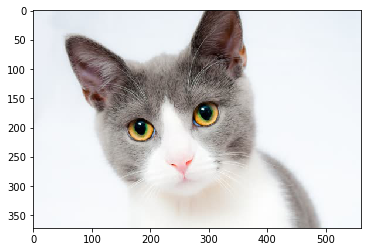

In [3]:
import torch
import torchvision as tv
import math

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [4]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])
CPU times: user 3.58 s, sys: 10.1 ms, total: 3.59 s
Wall time: 3.6 s


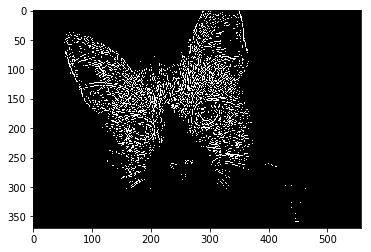

In [6]:
%%time
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')


### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


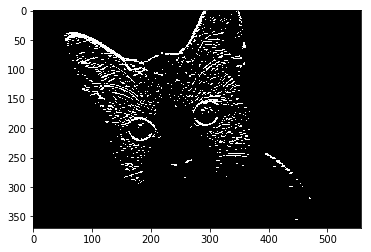

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [9]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


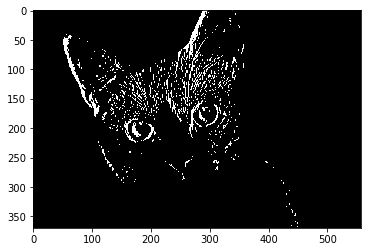

In [10]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])


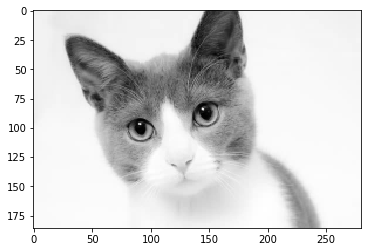

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

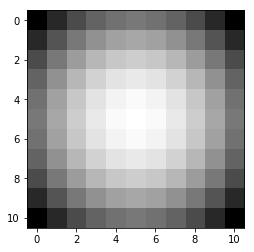

In [12]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


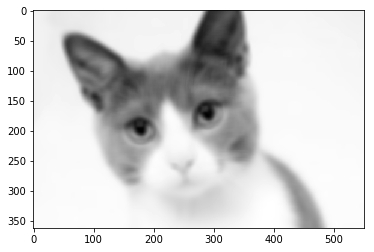

In [13]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [14]:
cat_tensor.size()

torch.Size([3, 372, 560])

In [15]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta = 0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        self.beta = beta
        self.epsilon = epsilon
        self.running_mean = torch.zeros(in_channels)
        self.running_var = torch.ones(in_channels)
        self.in_channels = in_channels
        self.afine = afine
        self.gamma = torch.FloatTensor(self.in_channels).uniform_(0, 1)
        self.b = torch.FloatTensor(self.in_channels).uniform_(0, 1)
        super().__init__()

        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        

        
        if self.training:
            # находимся в режиме обучения
            for i in range(self.in_channels):
                
                self.running_mean[i] = self.beta * self.running_mean[i] + (1 - self.beta) * (torch.mean(x[:, i, :, :]))
                self.running_var[i] = self.beta * self.running_var[i] + (1 - self.beta) * (torch.var(x[:, i, :, :]))
                
                x = ((x - self.running_mean[i]) / (self.running_var[i] + self.epsilon)**0.5)
            
                
        if self.afine:
            for i in range(self.in_channels):
                x[:, i, :, :] = (x[:, i, :, :] * self.gamma[i]) + self.b[i]
            
        return x


### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 372, 560])
torch.Size([3, 372, 560])


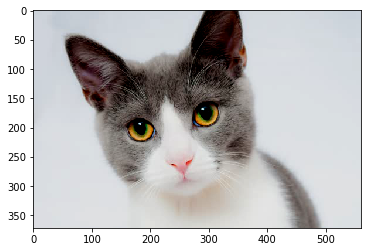

In [16]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
print (o_image.size())
o_image = o_image.squeeze(0)
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])
torch.Size([1, 3, 372, 560])
torch.Size([3, 372, 560])


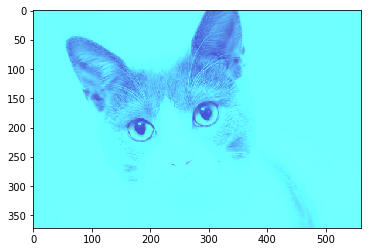

In [21]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
print (o_image.size())
o_image = bn(cat_tensor.unsqueeze(0))
print (o_image.size())
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [22]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [23]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


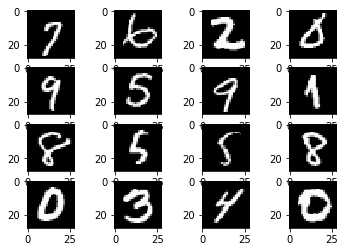

In [26]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [27]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.running_mean[0].int() ] 
            var_curve +=  [ bn.running_var[0].int() ]
    return mean_curve, var_curve

In [28]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

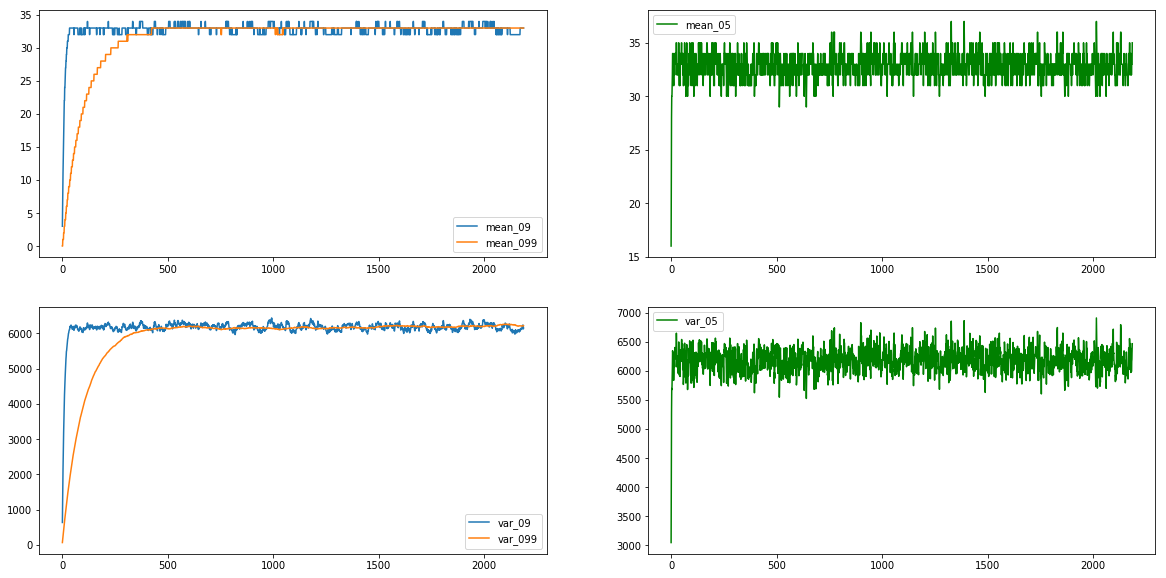

In [29]:
plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

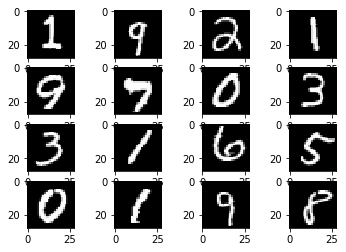

In [30]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    R = I
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{0.5}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [40]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(grad) # нужно проинициализировать TODO
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(grad) # нужно проинициализировать TODO

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                state['avg'] = beta1 * state['avg'] + (1. - beta1) * grad
                state['avg_sq'] = beta2 * state['avg_sq'] + (1. - beta2) * grad**2

                # обновляем веса в p.data, 
                # TODO
                step_size = lr * ((1 - beta2 ** state['step']) ** 0.5 / 1 - beta1 ** state['step'] )
                p.data = p.data - state['avg'] * (step_size / (state['avg_sq'] + eps)**0.5)
            

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [41]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    state = self.state[p]
                    if len(state) == 0:
                        state['mmnt'] = torch.zeros_like(grad)
                    state['mmnt'] = state['mmnt'] * (1.-beta) - lr * grad   

                # обновляем веса
                # to do
                # p.data
                if beta == 0:
                    p.data = p.data - lr*grad
                else:
                    p.data = p.data + state['mmnt']

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [42]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [43]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [55]:
import tqdm

In [58]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in tqdm.tqdm_notebook(range(c_epoch)):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [59]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd_1e_1 = fit_net(15, net, optimizer) # обучаем сеть

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.121886742458422
Do epoch 1 with loss 0.04284966852521046
Do epoch 2 with loss 0.03404974561332839
Do epoch 3 with loss 0.02824997350021645
Do epoch 4 with loss 0.02491505469600523
Do epoch 5 with loss 0.023012058425287595
Do epoch 6 with loss 0.019859020162593517
Do epoch 7 with loss 0.01838484910671494
Do epoch 8 with loss 0.015015315095828884
Do epoch 9 with loss 0.01452954963810323
Do epoch 10 with loss 0.013273761585988463
Do epoch 11 with loss 0.011640045214418849
Do epoch 12 with loss 0.011031217522200352
Do epoch 13 with loss 0.009764695479600573
Do epoch 14 with loss 0.008870946929015468


In [60]:
learning_rate = 1e-2 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd_1e_2 = fit_net(15, net, optimizer) # обучаем сеть

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.22037879279148215
Do epoch 1 with loss 0.0714594389839591
Do epoch 2 with loss 0.053928753346627195
Do epoch 3 with loss 0.044787374737740214
Do epoch 4 with loss 0.03898158170722313
Do epoch 5 with loss 0.03536790002956748
Do epoch 6 with loss 0.031505304272446286
Do epoch 7 with loss 0.029140541187747733
Do epoch 8 with loss 0.026649308837626586
Do epoch 9 with loss 0.024442662175354696
Do epoch 10 with loss 0.022343347871963105
Do epoch 11 with loss 0.021648960389881632
Do epoch 12 with loss 0.019437113484673484
Do epoch 13 with loss 0.01846529003769282
Do epoch 14 with loss 0.01712944436942708


In [61]:
learning_rate = 1e-3 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd_1e_3 = fit_net(15, net, optimizer) # обучаем сеть

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 1.0377996227255575
Do epoch 1 with loss 0.2952386726547334
Do epoch 2 with loss 0.19706368807466487
Do epoch 3 with loss 0.15825358153438807
Do epoch 4 with loss 0.13533330221916368
Do epoch 5 with loss 0.12003283401602853
Do epoch 6 with loss 0.10864573710303793
Do epoch 7 with loss 0.10021272746596535
Do epoch 8 with loss 0.09286066230895806
Do epoch 9 with loss 0.08712045321003399
Do epoch 10 with loss 0.08202291242556863
Do epoch 11 with loss 0.07798482159473714
Do epoch 12 with loss 0.07399034758695032
Do epoch 13 with loss 0.07124545465717046
Do epoch 14 with loss 0.06801729898339381


## SGD с моментом

In [62]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum_1e_1 = fit_net(15, net, optimizer)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11803394726042776
Do epoch 1 with loss 0.05026391712726389
Do epoch 2 with loss 0.03932384709190112
Do epoch 3 with loss 0.0336199409281984
Do epoch 4 with loss 0.0296915331263492
Do epoch 5 with loss 0.025865883016673516
Do epoch 6 with loss 0.022878969739739297
Do epoch 7 with loss 0.021256167385395007
Do epoch 8 with loss 0.01913236900584906
Do epoch 9 with loss 0.017539076803479502
Do epoch 10 with loss 0.016414638225433757
Do epoch 11 with loss 0.013738566182577615
Do epoch 12 with loss 0.014220572476606146
Do epoch 13 with loss 0.012168585187804497
Do epoch 14 with loss 0.011230569705878102


In [63]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum_1e_2 = fit_net(15, net, optimizer)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.26598319509392415
Do epoch 1 with loss 0.07669725552180831
Do epoch 2 with loss 0.0586226564812017
Do epoch 3 with loss 0.04958149304619433
Do epoch 4 with loss 0.04364271100847264
Do epoch 5 with loss 0.039255147335678676
Do epoch 6 with loss 0.0360143100106122
Do epoch 7 with loss 0.033962844548620044
Do epoch 8 with loss 0.030948943912873925
Do epoch 9 with loss 0.028411698688177632
Do epoch 10 with loss 0.026331118264997393
Do epoch 11 with loss 0.025146244161059227
Do epoch 12 with loss 0.02359869093329709
Do epoch 13 with loss 0.022187853716637482
Do epoch 14 with loss 0.02137260428222282


In [64]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum_1e_3 = fit_net(15, net, optimizer)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.8742083672197322
Do epoch 1 with loss 0.2527466176829765
Do epoch 2 with loss 0.1796997791666335
Do epoch 3 with loss 0.14612224362841686
Do epoch 4 with loss 0.12566545252719316
Do epoch 5 with loss 0.1106607212178719
Do epoch 6 with loss 0.10030294427410565
Do epoch 7 with loss 0.0919837574327597
Do epoch 8 with loss 0.08522284450967615
Do epoch 9 with loss 0.07950913384522702
Do epoch 10 with loss 0.07495399755283093
Do epoch 11 with loss 0.07035509912211109
Do epoch 12 with loss 0.06699453069431137
Do epoch 13 with loss 0.06401650783033964
Do epoch 14 with loss 0.06122696947154794


## Adam

In [65]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam_1e_1 = fit_net(15, net, optimizer)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 37.26150637666112
Do epoch 1 with loss 2.1415289814852665
Do epoch 2 with loss 2.203813323649741
Do epoch 3 with loss 2.3025848865509033
Do epoch 4 with loss 2.3025848865509033
Do epoch 5 with loss 2.3025848865509033
Do epoch 6 with loss 2.3025848865509033
Do epoch 7 with loss 2.3025848865509033
Do epoch 8 with loss 2.3025848865509033
Do epoch 9 with loss 2.3025848865509033
Do epoch 10 with loss 2.3025848865509033
Do epoch 11 with loss 2.3025848865509033
Do epoch 12 with loss 2.3025848865509033
Do epoch 13 with loss 2.3025848865509033
Do epoch 14 with loss 2.3025848865509033


In [66]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam_1e_2 = fit_net(15, net, optimizer)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 2.948342130889509
Do epoch 1 with loss 2.3025848865509033
Do epoch 2 with loss 2.3025848865509033
Do epoch 3 with loss 2.3025848865509033
Do epoch 4 with loss 2.3025848865509033
Do epoch 5 with loss 2.3025848865509033
Do epoch 6 with loss 2.3025848865509033
Do epoch 7 with loss 2.3025848865509033
Do epoch 8 with loss 2.3025848865509033
Do epoch 9 with loss 2.3025848865509033
Do epoch 10 with loss 2.3025848865509033
Do epoch 11 with loss 2.3025848865509033
Do epoch 12 with loss 2.3025848865509033
Do epoch 13 with loss 2.3025848865509033
Do epoch 14 with loss 2.3025848865509033


In [67]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam_1e_3 = fit_net(15, net, optimizer)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.24547591054949194
Do epoch 1 with loss 0.047849976388242725
Do epoch 2 with loss 0.03728670184340824
Do epoch 3 with loss 0.030890141133854365
Do epoch 4 with loss 0.02641149607214908
Do epoch 5 with loss 0.023891539441078396
Do epoch 6 with loss 0.020713231708150943
Do epoch 7 with loss 0.019521477751035257
Do epoch 8 with loss 0.017605621842935744
Do epoch 9 with loss 0.016466902103062137
Do epoch 10 with loss 0.014047077984285507
Do epoch 11 with loss 0.013799225736901703
Do epoch 12 with loss 0.012455400323071979
Do epoch 13 with loss 0.012065374614797774
Do epoch 14 with loss 0.011164888065047715


# Кривые обучения

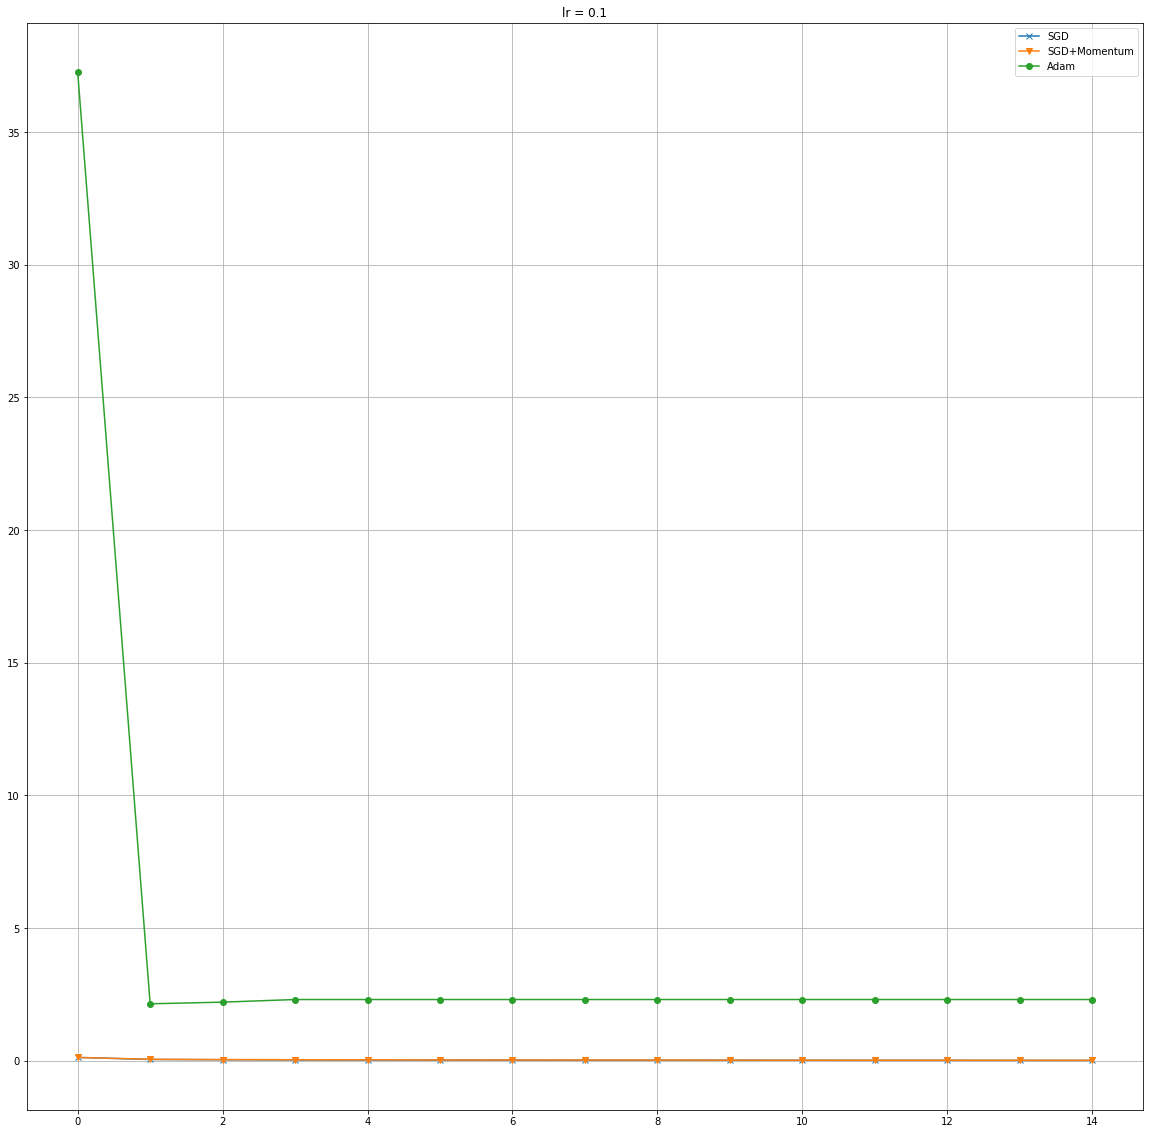

In [87]:
plt.figure(figsize=(20,20))

plt.title('lr = 0.1')
plt.plot(loss_curve_sgd_1e_1, 'x-', label="SGD")
plt.plot(loss_curve_sgd_momentum_1e_1, 'v-', label="SGD+Momentum")
plt.plot(loss_curve_adam_1e_1, 'o-', label='Adam' )
plt.grid()
plt.legend();

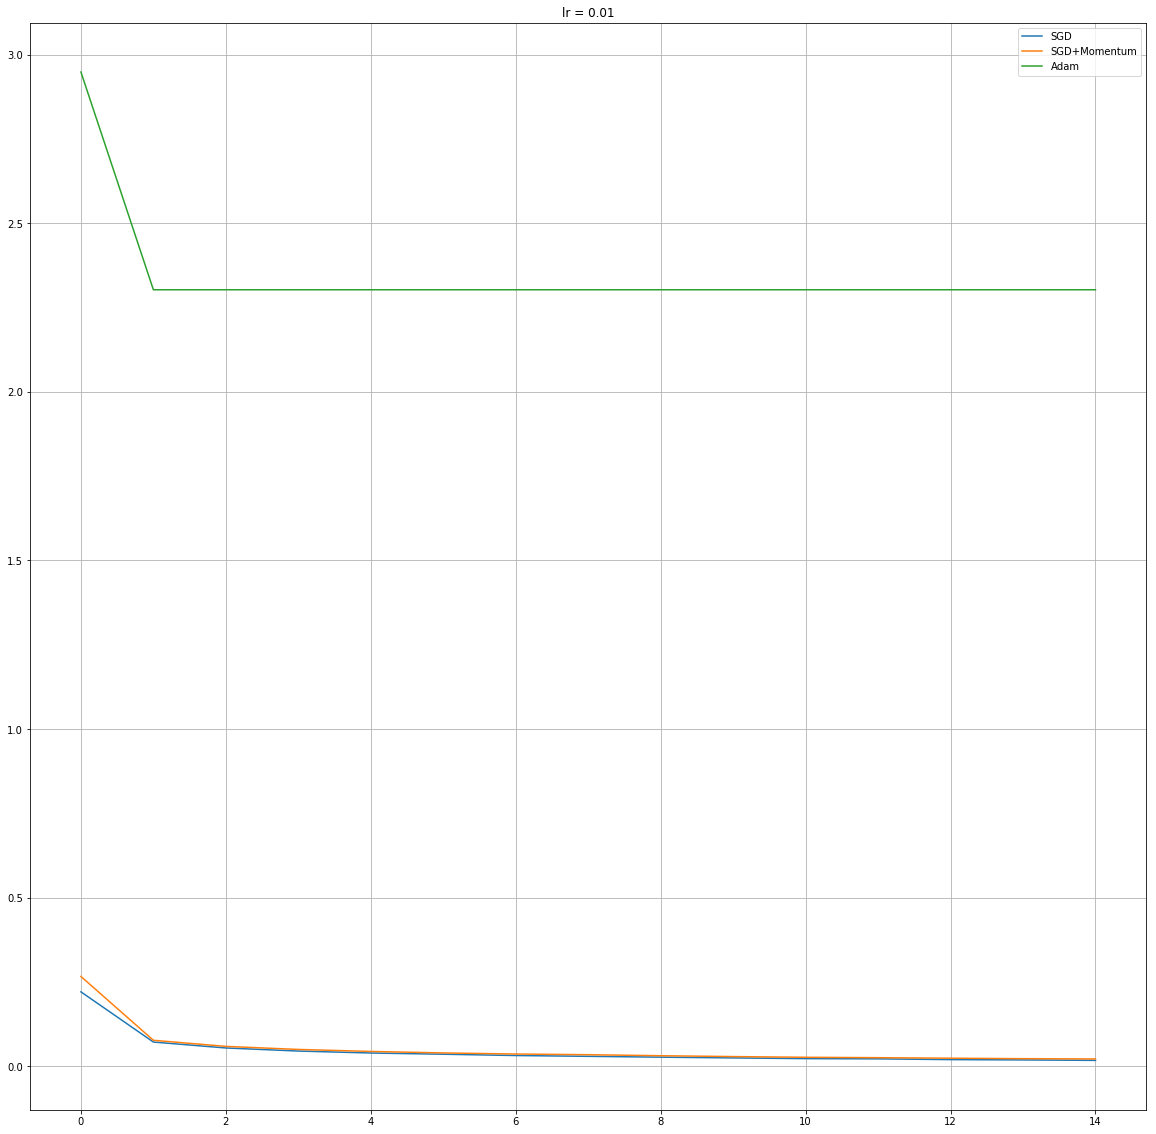

In [88]:
plt.figure(figsize=(20,20))
plt.title('lr = 0.01')
plt.plot(loss_curve_sgd_1e_2,label="SGD")
plt.plot(loss_curve_sgd_momentum_1e_2,label="SGD+Momentum")
plt.plot(loss_curve_adam_1e_2, label='Adam' )
plt.grid()
plt.legend();

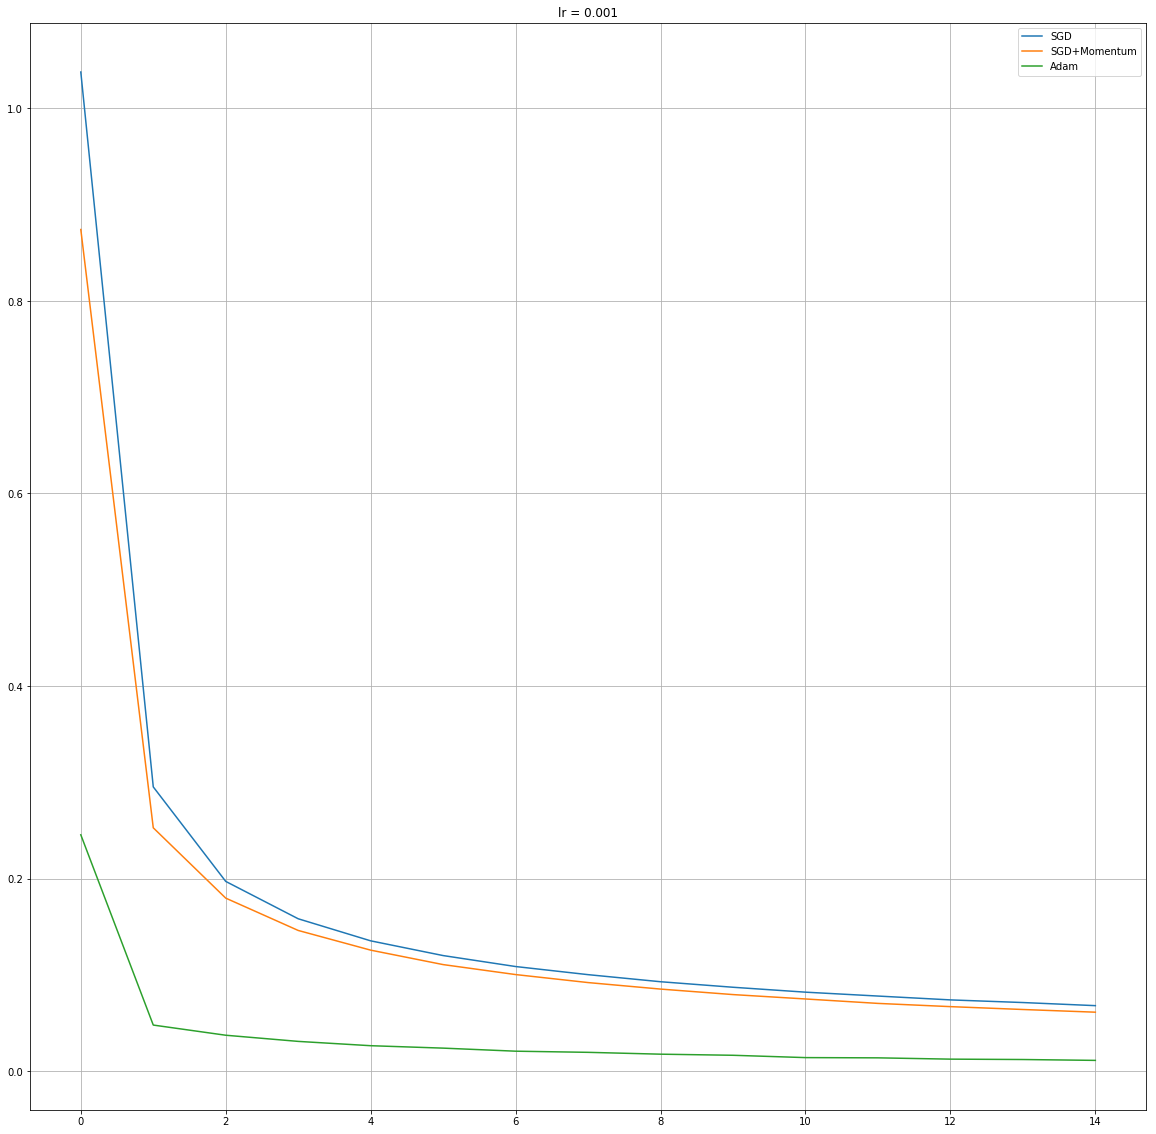

In [89]:
plt.figure(figsize=(20,20))
plt.title('lr = 0.001')
plt.plot(loss_curve_sgd_1e_3,label="SGD")
plt.plot(loss_curve_sgd_momentum_1e_3,label="SGD+Momentum")
plt.plot(loss_curve_adam_1e_3, label='Adam' )
plt.grid()
plt.legend();

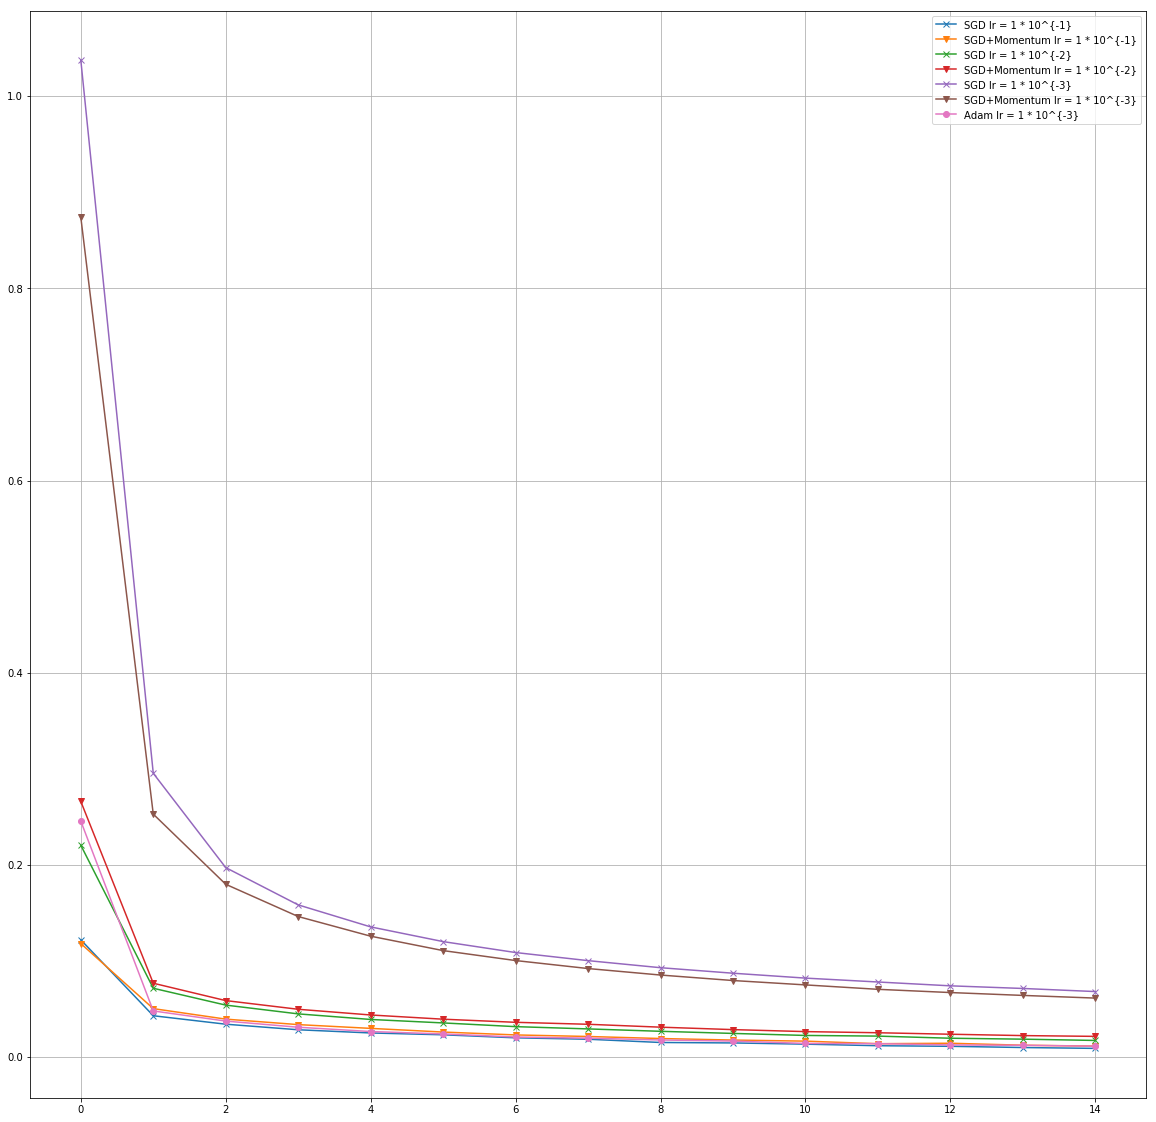

In [93]:
plt.figure(figsize=(20,20))
plt.plot(loss_curve_sgd_1e_1, 'x-', label= r"SGD lr = 1 * 10^{-1} ")
plt.plot(loss_curve_sgd_momentum_1e_1, 'v-', label=r"SGD+Momentum lr = 1 * 10^{-1}")
#plt.plot(loss_curve_adam_1e_1[1:], 'o-',  label=r'Adam lr = 1 * 10^{-1}' )
plt.plot(loss_curve_sgd_1e_2, 'x-', label=r"SGD lr = 1 * 10^{-2}")
plt.plot(loss_curve_sgd_momentum_1e_2, 'v-', label=r"SGD+Momentum lr = 1 * 10^{-2}")
#plt.plot(loss_curve_adam_1e_2, 'o-', label=r'Adam lr = 1 * 10^{-2}' )
plt.plot(loss_curve_sgd_1e_3, 'x-', label=r"SGD lr = 1 * 10^{-3}")
plt.plot(loss_curve_sgd_momentum_1e_3, 'v-', label=r"SGD+Momentum lr = 1 * 10^{-3}")
plt.plot(loss_curve_adam_1e_3, 'o-', label=r'Adam lr = 1 * 10^{-3}' )
plt.grid()
plt.legend();

### Выводы

_пишем выводы по сходимости и скорости обучения: Adam, SGD, SGD+momentum, с различными параметрами обучения lr и betas_

Сравним скорости обучения и сходимости трех моделей, определенных выше (Adam, SGD, SGD+Momentum):
- при малых значениях lr = 0.001 Adam показывает себя лучше всех, все модели сходятся с одинаковой скоростью, но Adam к гораздо меньшему Loss'у

- при повышении lr = 0.01 Adam становится неприменим, зато модели SGD и SGD+Momentum показывают хорошую сходимость и достаточно низкий Loss (две модели сходятся одновременно, но SGD+Momentum к немного меньшему Loss'y) 

- при значении lr = 0.1 Adam снова выходит из рассмотрения, а модели SGD и SGD+Momentum показывают еще лучшую сходимость на этот раз SGD показывает наименьший Loss среди моделей 

### Вывод: Adam показывает лучшие результаты среди моделей, но только для малых lr, если lr достаточно большие стоит использовать SGD или SGD+Momentum, последний для средних значений lr